In [2]:
import pandas as pd
import numpy as np
from itertools import chain
from scipy.stats import chi2_contingency
import cooler
import bioframe
import cooltools
from cooltools.lib.numutils import fill_diag
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn2

### 1. Call loops

In [ ]:
#set path to the merged sampled maps
path_to_maps = "../data/"
binsize = 10_000
clr_HCmin_10 = cooler.Cooler(f'{path_to_maps}/NeuNminus.sampled.1000.mcool::/resolutions/{binsize}')
clr_HCplus_10 = cooler.Cooler(f'{path_to_maps}/NeuNplus.sampled.1000.mcool::/resolutions/{binsize}')
clrs_10 = [clr_HCplus_10, clr_HCmin_10]

In [18]:
n_proc = 10
hg38_chromsizes = bioframe.fetch_chromsizes('hg38')
hg38_cens = bioframe.fetch_centromeres('hg38')
hg38_arms = bioframe.make_chromarms(hg38_chromsizes, hg38_cens)

In [ ]:
expected_HCmin_10 = cooltools.expected_cis(
    clr_HCmin_10,
    view_df=hg38_arms,
    nproc=n_proc,
)
expected_HCplus_10 = cooltools.expected_cis(
    clr_HCplus_10,
    view_df=hg38_arms,
    nproc=n_proc,
)
expected_HCplus_10.to_csv("../data/expected_HCplus_10.csv", index=False)
expected_HCmin_10.to_csv("../data/expected_HCmin_10.csv", index=False)

In [ ]:
dots_df_HCplus_10_ext = cooltools.dots(
    clr_HCplus_10,
    expected=expected_HCplus_10,
    view_df=hg38_arms,
    max_loci_separation=6_000_000,
    max_nans_tolerated=2,
  
    lambda_bin_fdr=0.05,
    clustering_radius=20_000,
    cluster_filtering=None,
    tile_size=5_000_000,
    nproc=15,
)

dots_df_HCmin_10_ext = cooltools.dots(
    clr_HCmin_10,
    expected=expected_HCmin_10,
    view_df=hg38_arms,
    max_loci_separation=6_000_000,
    max_nans_tolerated=2,
  
    lambda_bin_fdr=0.05,
    clustering_radius=20_000,
    cluster_filtering=None,
    tile_size=5_000_000,
    nproc=15,
)

In [ ]:
dots_df_HCplus_10_ext["loop_num"] = range(1,dots_df_HCplus_10_ext.shape[0] + 1)
dots_df_HCmin_10_ext["loop_num"] = range(1,dots_df_HCmin_10_ext.shape[0] + 1)
dots_df_HCmin_10_ext = dots_df_HCmin_10_ext[["chrom1", "start1", "end1", "chrom2", "start2","end2" , 'loop_num']]
dots_df_HCplus_10_ext = dots_df_HCplus_10_ext[["chrom1", "start1", "end1", "chrom2", "start2","end2" , 'loop_num']]

def save_loops(format = 'tsv'):
    if format == 'csv':
        dots_df_HCplus_10_ext.to_csv("../data/dots_df_HCplus_10_ext.csv", index=False)
        dots_df_HCmin_10_ext.to_csv("../data/dots_df_HCmin_10_ext.csv", index=False)
    elif format == 'tsv':
        dots_df_HCplus_10_ext.to_csv("../data/dots_df_HCplus_10_ext_maps112022.tsv", sep="\t", index=False)
        dots_df_HCmin_10_ext.to_csv("../data/dots_df_HCmin_10_ext_maps112022.tsv",  sep="\t", index=False)

In [ ]:
save_loops(format = 'csv')
save_loops(format = 'tsv')

### 2. Inspect general properties

In [87]:
dots_df_HCplus_10_ext= pd.read_csv("../data/dots_df_HCplus_10_ext_maps112022.tsv", sep="\t")
dots_df_HCmin_10_ext= pd.read_csv("../data/dots_df_HCmin_10_ext_maps112022.tsv",  sep="\t")
dots_df_HCplus_10_ext["cell_type"] = "NeuN+"
dots_df_HCmin_10_ext["cell_type"] = "NeuN-"
all_loops_10_ext = pd.concat([dots_df_HCplus_10_ext[["chrom1", "start1", "end1", "chrom2", "start2","end2", "loop_length_mb", "cell_type"]],
                              dots_df_HCmin_10_ext[["chrom1", "start1", "end1", "chrom2", "start2","end2", "loop_length_mb", "cell_type"]]]).drop_duplicates().reset_index(drop=True)
clrs_10 = [clr_HCplus_10, clr_HCmin_10]
exps_10 = [expected_HCplus_10 , expected_HCmin_10]

In [ ]:
avr_loops, avr_loops_all = [], []
for i in range(2):    
    stack = cooltools.pileup(clrs_10[i], 
                                all_loops_10_ext, 
                                 hg38_arms,                                 
                                 expected_df=exps_10[i], 
                                 flank=200000,
                                 nproc=10)
    stack[:, :, np.all(stack == 0, axis=(0,1))] = np.nan
    avr_loops_all.append(stack)
    avr_loops.append(np.nanmean(stack, axis=0))

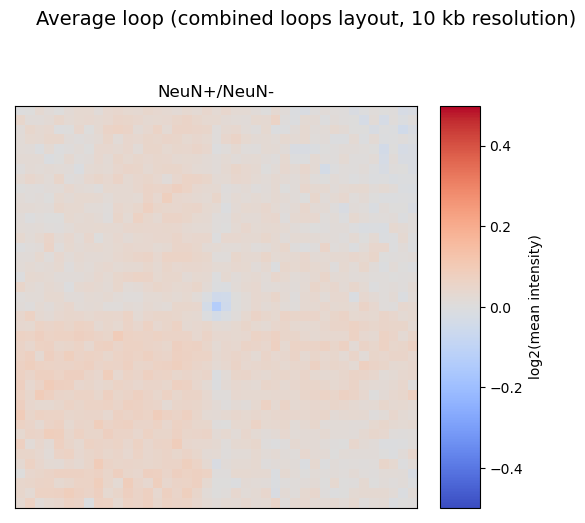

In [49]:
plt.rcParams['axes.facecolor'] = 'white'
fig, axs = plt.subplots(1, 2,figsize=(6,6), 
                        gridspec_kw={'width_ratios': [1, 0.1] , 'wspace':0.1})
vmin=-0.5
vmax=0.5
im = axs[0].imshow(np.log(avr_loops[0]/ avr_loops[1]), cmap='coolwarm',
                vmin = vmin, vmax = vmax )
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].set_title('NeuN+/NeuN-')
plt.colorbar(im, cax=axs[1])
axs[1].set_box_aspect(10) # adjust colorbar height
axs[1].set_ylabel("log2(mean intensity)")
plt.suptitle('Average loop (combined loops layout, 10 kb resolution)', fontsize = 14, x=0.61,y = 0.99);


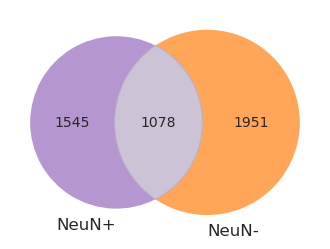

In [52]:
sns.set_style("white")
plt.figure(figsize=(4,4))
my_pal = {"NeuN+": sns.color_palette()[4], "NeuN-":sns.color_palette()[1]}
c = venn2(subsets = (1545,1951, 1078), 
          set_labels = ('NeuN+', 'NeuN-'),
         set_colors=(sns.color_palette()[4],sns.color_palette()[1]),alpha=0.69)
c.get_patch_by_id('11').set_color('#b7a9c4')
plt.show()

Text(0.5, 0, 'Cell type')

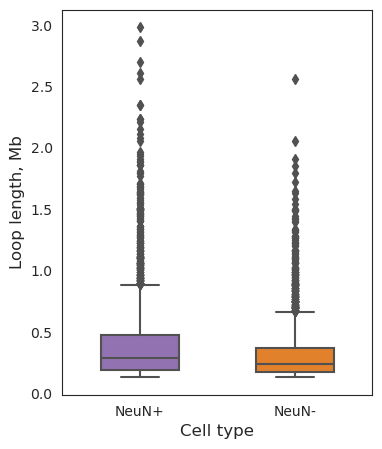

In [88]:
sns.set_style("white")
plt.figure(figsize=(4,5))
my_pal = {"NeuN+": sns.color_palette()[4], "NeuN-":sns.color_palette()[1]}
ax= sns.boxplot(data=all_loops_10_ext, x="cell_type", y="loop_length_mb",  width=0.5,
                showmeans=False, palette=my_pal, 
                meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"} );
plt.ylabel("Loop length, Mb", size=12)
plt.xlabel("Cell type", size=12)

In [85]:
all_loops_10_ext

,chrom1,start1,end1,chrom2,start2,end2,loop_length_mb
0,chr10,23990000,24000000,chr10,24190000,24200000,0.21
1,chr10,30780000,30790000,chr10,31150000,31160000,0.38
2,chr10,28240000,28250000,chr10,28380000,28390000,0.15
3,chr10,22000000,22010000,chr10,22310000,22320000,0.32
4,chr10,20860000,20870000,chr10,21260000,21270000,0.41
...,...,...,...,...,...,...,...
4910,chrX,129310000,129320000,chrX,129460000,129470000,0.16
4911,chrX,130070000,130080000,chrX,130190000,130200000,0.13
4912,chrX,110450000,110460000,chrX,110840000,110850000,0.40
4913,chrX,68820000,68830000,chrX,69220000,69230000,0.41


### 3. Identify loops groups

In [ ]:
all_loops_10_ext_hic_plus = []
stack = cooltools.pileup(clrs_10[0], 
                             all_loops_10_ext, 
                             hg38_arms,                                 
                             expected_df=exps_10[0], 
                             flank=200000,
                             nproc=12)

stack[:, :, np.all(stack == 0, axis=(0,1))] = np.nan
all_loops_10_ext_hic_plus.append(stack)
all_loops_10_ext_hic_plus = all_loops_10_ext_hic_plus[0]


In [67]:
all_loops_10_ext_hic_plus_20_20 = []
for i in range(all_loops_10_ext_hic_plus.shape[0]):
    all_loops_10_ext_hic_plus_20_20.append(all_loops_10_ext_hic_plus[i][20,20])

In [ ]:
all_loops_10_ext_hic_minus = []
stack = cooltools.pileup(clrs_10[1], 
                             all_loops_10_ext, 
                             hg38_arms,                                 
                             expected_df=exps_10[1], 
                             flank=200000,
                             nproc=12)

stack[:, :, np.all(stack == 0, axis=(0,1))] = np.nan
all_loops_10_ext_hic_minus.append(stack)
all_loops_10_ext_hic_minus = all_loops_10_ext_hic_minus[0]


In [68]:
all_loops_10_ext_hic_minus_20_20 = []
for i in range(all_loops_10_ext_hic_minus.shape[0]):
    all_loops_10_ext_hic_minus_20_20.append(all_loops_10_ext_hic_minus[i][20,20])

In [ ]:
all_loops_10_ext_hic = [i/k for i, k in zip(all_loops_10_ext_hic_plus_20_20, all_loops_10_ext_hic_minus_20_20)]
all_loops_10_ext["NeuN+"] = all_loops_10_ext_hic_plus_20_20
all_loops_10_ext["NeuN-"] = all_loops_10_ext_hic_minus_20_20
all_loops_10_ext["NeuN+/NeuN-"] = all_loops_10_ext_hic

In [ ]:
groups = np.quantile(np.array(all_loops_10_ext["NeuN+/NeuN-"].tolist()), [0,0.25,0.5,0.75,1])
print(groups)
loops_groups = []
for item in all_loops_10_ext["NeuN+/NeuN-"].tolist():
    if item <=groups[1]:
        loops_groups.append(0)
    if item <=groups[2] and item > groups[1]:
        loops_groups.append(1)
    if item <=groups[3] and item > groups[2]:
        loops_groups.append(2)
    if item > groups[3]:
        loops_groups.append(3)
all_loops_10_ext["loop_group"] = loops_groups

In [78]:
loops_cooltools_groups = []
num_groups = []
for group in [0,1,2,3]:
    ind_list = all_loops_10_ext[all_loops_10_ext.loop_group == group].index.tolist() 
    loops_cooltools_groups_ind = []
    for i in ind_list:
        loops_cooltools_groups_ind.append(all_loops_10_ext_hic_plus[i] / all_loops_10_ext_hic_minus[i])
    loops_cooltools_groups_ind = np.array(loops_cooltools_groups_ind)
    loops_cooltools_groups_ind[np.isinf(loops_cooltools_groups_ind)] = np.nan
    loops_cooltools_groups.append(np.nanmean(loops_cooltools_groups_ind, axis=0))
    num_groups.append(len(ind_list))

/tmp/ipykernel_808099/2747411422.py:7: RuntimeWarning: divide by zero encountered in divide
  loops_cooltools_groups_ind.append(all_loops_10_ext_hic_plus[i] / all_loops_10_ext_hic_minus[i])
/tmp/ipykernel_808099/2747411422.py:7: RuntimeWarning: invalid value encountered in divide
  loops_cooltools_groups_ind.append(all_loops_10_ext_hic_plus[i] / all_loops_10_ext_hic_minus[i])


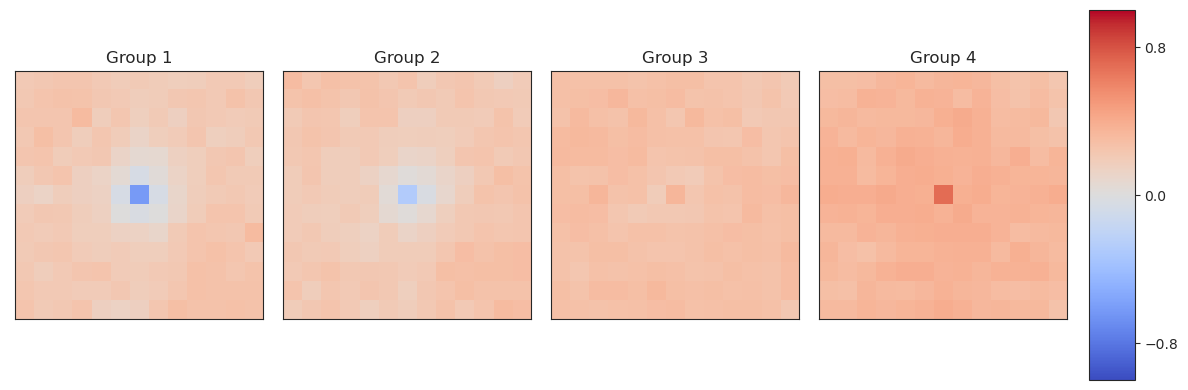

In [79]:
a=14
sns.set_style("ticks")
fig, axs = plt.subplots(1, 5, figsize=(12,4), 
                        gridspec_kw={'width_ratios': [1, 1, 1,1, 0.2]})
cnt=0
n_count = 0
for i in range(4):
        im = axs[i].imshow(np.log(loops_cooltools_groups[cnt][0+a:-a, 0+a:-a]), 
                              cmap='coolwarm',
                              vmin=-1, vmax=1)
        axs[i].set_xticks([])
        axs[i].set_yticks([])
        cnt+=1
        n_count+=1
vmin=-0.8
vmax=0.8
axs[0].set_title('Group 1');
axs[1].set_title('Group 2');
axs[2].set_title('Group 3');
axs[3].set_title('Group 4');
plt.colorbar(im, cax=axs[4], ticks = [vmin, 0 , vmax])
axs[4].set_box_aspect(8) 
plt.tight_layout()
plt.subplots_adjust( hspace=0.05)  